# This notebook contains:
* Function to mask radar points not within the hovmoller transect region (Cairns & Willis)
* Plotting for overlayed BT and rain rate data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
import dask.array as da
import dask.dataframe as dd
import dask.bag as db
import dask.distributed

# Read in radar data

In [6]:
def path_to_radar_ds(radar_site_no,variable):
    list = ["202112","202201","202202"]
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/"+variable+"/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list
towns_radar_files = path_to_radar_ds("73","REFLECTIVITY")
towns_radar_rrfiles = path_to_radar_ds("73","RAINRATE")
# cairns_radar_files = path_to_radar_ds("19",RAINRATE)
# willis_radar_files = path_to_radar_ds("41",RAINRATE)

In [11]:
def read_netcdf(file_path,file_path_ref,cairns=None,bb=None):
    with xr.open_mfdataset(file_path_ref) as ds:
        # Perform any processing on the dataset
        ds_ref = xr.open_mfdataset(file_path_ref).reflectivity
        if cairns==True:
            polygon = Polygon([
                (-150000, 20000),
                (-150000, -20000),
                (150000, -20000),
                (150000, 20000),
            ])
        else:
            polygon = Polygon([
                        (-150000, -39000),
                        (-150000, -79000),
                        (150000, -79000),
                        (150000, -39000),
                    ])
        gdf = gpd.GeoDataFrame({'geometry': [polygon]})
        # for cairns
        mask = regionmask.mask_geopandas(gdf, ds.x, ds.y,wrap_lon=False) 
        masked_ds = ds.rainrate.where(~mask.isnull()) 
        mean_rr = masked_ds.mean(dim='time')
        if bb==True:
            masked_beam_blockage = xr.where((mean_rr < 0.8), np.nan,mean_rr) # 1.2 for cairns, 0.8 for townsville
            mask_ds = ds_ref.where(~masked_beam_blockage.isnull()) 
        else:
            mask_ds = ds_ref.where(~mean_rr.isnull()) 
        
        # For example, compute mean of a variable
        result = mask_ds.fillna(0) #mask_ds, fill nans (times with no rain) as zeros
    return result

In [12]:
towns_ref = read_netcdf(towns_radar_rrfiles,towns_radar_files,cairns=False,bb=True)

AttributeError: 'Dataset' object has no attribute 'rainrate'

In [107]:
%%time
# ne_cairns_data = read_netcdf(cairns_radar_files,ne_wind_times,cairns=True,bb=True) 
# se_cairns_data = read_netcdf(cairns_radar_files,se_wind_times,cairns=True,bb=True) 
sw_cairns_data = read_netcdf(cairns_radar_files,sw_wind_times,cairns=True,bb=True) 
# nw_cairns_data = read_netcdf(cairns_radar_files,nw_wind_times,cairns=True,bb=True) 

CPU times: user 16 s, sys: 1.31 s, total: 17.3 s
Wall time: 18.3 s


In [9]:
ne_willis_data = read_netcdf(willis_radar_files,ne_wind_times,cairns=False,bb=False)
se_willis_data = read_netcdf(willis_radar_files,se_wind_times,cairns=False,bb=False)
sw_willis_data = read_netcdf(willis_radar_files,sw_wind_times,cairns=False,bb=False)
nw_willis_data = read_netcdf(willis_radar_files,nw_wind_times,cairns=False,bb=False)

In [108]:
# ne_rr_cairns = ne_cairns_data.groupby(ne_cairns_data.time.dt.hour).mean(dim=["y","time"])
# se_rr_cairns = se_cairns_data.groupby(se_cairns_data.time.dt.hour).mean(dim=["y","time"])
sw_rr_cairns = sw_cairns_data.groupby(sw_cairns_data.time.dt.hour).mean(dim=["y","time"])
# nw_rr_cairns = nw_cairns_data.groupby(nw_cairns_data.time.dt.hour).mean(dim=["y","time"])

In [11]:
ne_rr_willis = ne_willis_data.groupby(ne_willis_data.time.dt.hour).mean(dim=["y","time"])
se_rr_willis = se_willis_data.groupby(se_willis_data.time.dt.hour).mean(dim=["y","time"])
sw_rr_willis = sw_willis_data.groupby(sw_willis_data.time.dt.hour).mean(dim=["y","time"])
nw_rr_willis = nw_willis_data.groupby(nw_willis_data.time.dt.hour).mean(dim=["y","time"])

In [109]:
%%time
# ne_result = ne_rr_cairns.compute()
# se_result = se_rr_cairns.compute()
sw_result = sw_rr_cairns.compute()
# nw_result = nw_rr_cairns.compute()

CPU times: user 1min 51s, sys: 3.85 s, total: 1min 54s
Wall time: 1min 39s


In [13]:
%%time
ne_resultW = ne_rr_willis.compute()
se_resultW = se_rr_willis.compute()
sw_resultW = sw_rr_willis.compute()
nw_resultW = nw_rr_willis.compute()

CPU times: user 10min 52s, sys: 24.5 s, total: 11min 17s
Wall time: 9min 41s


In [14]:
cairns_long = xr.open_dataset('/g/data/rq0/level_2/19/RAINRATE/19_20120101_rainrate.nc', engine="h5netcdf", chunks="auto") 
cairns_lon = cairns_long.longitude.isel(y=150).values
willis_long = xr.open_dataset('/g/data/rq0/level_2/41/RAINRATE/41_20120101_rainrate.nc', engine="h5netcdf", chunks="auto") 
willis_lon = willis_long.longitude.isel(y=150).values
# cairns_lon[:-6]
cairns_latt = xr.open_dataset('/g/data/rq0/level_2/19/RAINRATE/19_20120101_rainrate.nc', engine="h5netcdf", chunks="auto") 
cairns_lat = cairns_latt.latitude.isel(x=150).values
willis_latt = xr.open_dataset('/g/data/rq0/level_2/41/RAINRATE/41_20120101_rainrate.nc', engine="h5netcdf", chunks="auto") 
willis_lat = willis_latt.latitude.isel(x=150).values

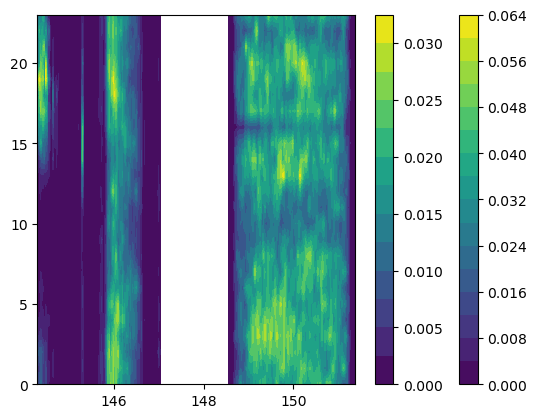

In [110]:
ne_cairns_aest = np.roll(ne_result,shift=10,axis=0)
se_cairns_aest = np.roll(se_result,shift=10,axis=0)
sw_cairns_aest = np.roll(sw_result,shift=10,axis=0)
nw_cairns_aest = np.roll(nw_result,shift=10,axis=0)

ne_willis_aest = np.roll(ne_resultW,shift=10,axis=0)
se_willis_aest = np.roll(se_resultW,shift=10,axis=0)
sw_willis_aest = np.roll(sw_resultW,shift=10,axis=0)
nw_willis_aest = np.roll(nw_resultW,shift=10,axis=0)

cf1=plt.contourf(cairns_lon[3:-6],np.arange(0,24,1),se_cairns_aest[:, 3:-6],levels=15)
plt.colorbar(cf1)
cf2=plt.contourf(willis_lon,np.arange(0,24,1),se_willis_aest,levels=15)
plt.colorbar(cf2)


# transect plot

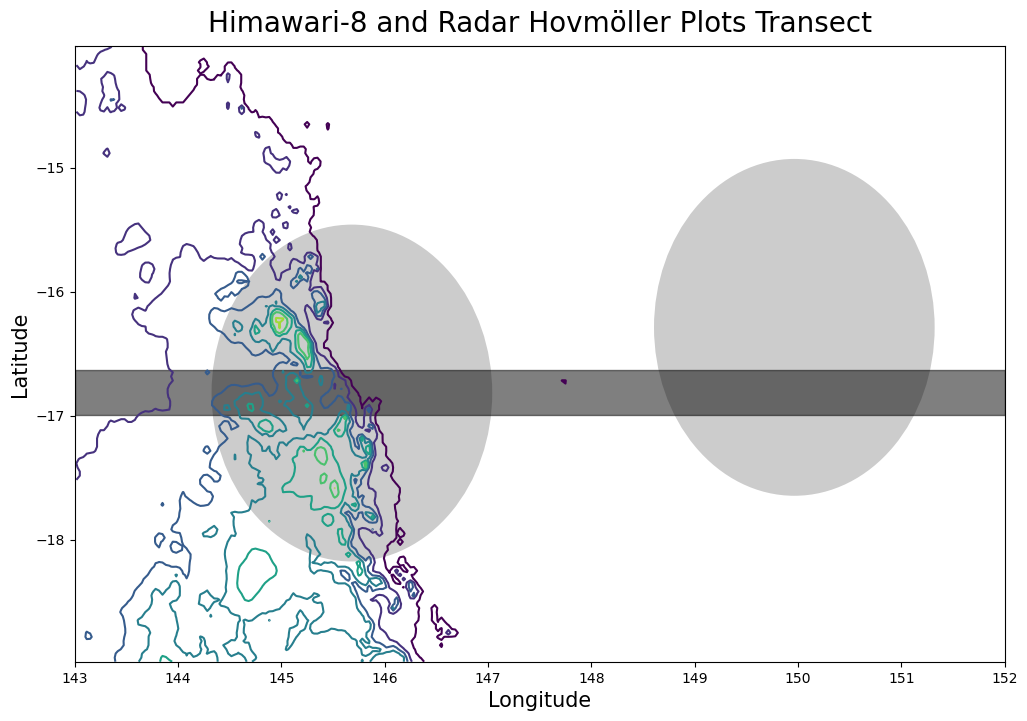

In [14]:
# plot horizontal transect
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(143,152),y=slice(-19,-14))#.sel(x=slice(140,155),y=slice(-22,-11))
lon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
lat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))
lon, lat = np.meshgrid(lon, lat)

fig, ax = plt.subplots(1,1,figsize=(12,8))
fig.patch.set_facecolor('white')
# changing between mask and masked_ds (bb with or without)
import matplotlib.patches as mpatches
circle_C = mpatches.Circle((145.683,-16.817),1.358,alpha=0.4,fc="grey") # Cairns
circle_W = mpatches.Circle((149.9646,-16.2874),1.358,alpha=0.4,fc="grey") # Willis Island
ax.add_patch(circle_C) 
ax.add_patch(circle_W)
polygon_C = mpatches.Polygon([(144.27374, -16.633728), (147.09222, -16.633728), (147.09222, -16.993225),(144.27374,-16.993225)], edgecolor='black')
polygon_W = mpatches.Polygon([(148.55927, -16.633728), ( 151.36993, -16.633728), ( 151.36993, -16.993225),(148.55927,-16.993225)], edgecolor='black', facecolor='none')
polygon_all = mpatches.Polygon([(143, -16.633728), (152, -16.633728), (152, -16.993225),(143,-16.993225)], edgecolor='black',facecolor="black",alpha=0.5)

# ax.add_patch(polygon_C)
# ax.add_patch(polygon_W)
ax.add_patch(polygon_all)
# ax.contourf(cairns_lon, cairns_lat, cairns_long.rainrate.mean(dim=['time']),levels=0,colors='grey',alpha=1)
# ax.contourf(willis_lon, willis_lat, willis_long.rainrate.mean(dim=['time']),levels=0,colors='grey',alpha=1)
# ax.contourf(cairns_lon, cairns_lat, cairns_plot,levels=1,colors="black",alpha=1)
# ax.contourf(willis_lon, willis_lat, willis_plot,levels=1,colors="black",alpha=1)

sel_lat_lon = ds_bath["z"]#.sel(x=slice(140,155),y=slice(-22,-11)) #(x=slice(144.3,147.2),y=slice(-18.5,-15.2) #towns:x=slice(145,148.2),y=slice(-21,-17.8)
cmapc = plt.get_cmap('viridis')
ax.contour(lon, lat,sel_lat_lon,levels=np.arange(0,1600,200),cmap=cmapc,alpha=1)
ax.set_ylabel("Latitude",fontsize=15)
ax.set_xlabel("Longitude",fontsize=15)
ax.set_xticks(np.arange(143,153,1))
ax.set_xlim(143,152)
ax.set_title("Himawari-8 and Radar Hovmöller Plots Transect",fontsize=20,pad=10);

# not using dask

In [15]:
# define function to open radar data JFMA 2012-2022; cairns=19; townsville=73; willis=41
def open_radar_ds(radar_site_no):
    list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] # 202203 and 202204 removed since not in radar data; radar data goes back to 08-2011
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return xr.open_mfdataset(files_list, engine="h5netcdf", chunks="auto") #={'time':-1})

In [16]:
%%time
# open radar ds
# ds_radar_T = open_radar_ds("73")
ds_radar_C = open_radar_ds("19")
ds_radar_W = open_radar_ds("41")

CPU times: user 2min 15s, sys: 1.04 s, total: 2min 16s
Wall time: 2min 17s


In [ ]:
%%time
# ds_radar_T = ds_radar_T.persist()
ds_radar_C = ds_radar_C.persist()
ds_radar_W = ds_radar_W.persist()

In [ ]:
# polygon for cairns - horizontal to also intersect the willis island radar site
polygon = Polygon([
            (-150000, 20000),
            (-150000, -20000),
            (150000, -20000),
            (150000, 20000),
        ])
polygonW = Polygon([
            (-150000, -35000),
            (-150000, -75000),
            (150000, -75000),
            (150000, -35000),
        ])
gdf = gpd.GeoDataFrame({'geometry': [polygon]})
gdfW = gpd.GeoDataFrame({'geometry': [polygonW]})
# for cairns
mask = regionmask.mask_geopandas(gdf, ds_radar_C.x, ds_radar_C.y,wrap_lon=False) 
maskW = regionmask.mask_geopandas(gdfW, ds_radar_W.x, ds_radar_W.y,wrap_lon=False) 

masked_ds = ds_radar_C.rainrate.where(~mask.isnull()) 
masked_dsW = ds_radar_W.rainrate.where(~maskW.isnull()) 

mean_rr = masked_ds.mean(dim='time')
mean_rrW = masked_dsW.mean(dim='time')

masked_beam_blockage = xr.where((mean_rr < 1.2), np.nan,mean_rr) # 1.2 for cairns, 0.8 for townsville
mask_ds = ds_radar_C.rainrate.where(~masked_beam_blockage.isnull()) # change for C or T

mask_dsW = ds_radar_W.rainrate.where(~mean_rrW.isnull()) 

In [ ]:
# plot horizontal transect
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))
lon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
lat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))
lon, lat = np.meshgrid(lon, lat)
dem = ds_bath['z'].data

fig, ax = plt.subplots(1,1,figsize=(14,6))
fig.patch.set_facecolor('white')
# changing between mask and masked_ds (bb with or without)
ax.contourf(ds_radar_C.longitude.isel(time=0), ds_radar_C.latitude.isel(time=0), masked_ds.mean(dim='time'),levels=1,colors="magenta",alpha=1)
ax.contourf(ds_radar_C.longitude.isel(time=0), ds_radar_C.latitude.isel(time=0), mask_ds.mean(dim='time'),levels=1,colors="black",alpha=1)
ax.contourf(ds_radar_W.longitude.isel(time=0), ds_radar_W.latitude.isel(time=0), mask_dsW.mean(dim='time'),levels=1,colors="black",alpha=1)

ax.contourf(ds_radar_W.longitude.isel(time=0), ds_radar_W.latitude.isel(time=0), ds_radar_W.rainrate.mean(dim=['time']),levels=1,colors='grey',alpha=0.3)
ax.contourf(ds_radar_C.longitude.isel(time=0), ds_radar_C.latitude.isel(time=0), ds_radar_C.rainrate.mean(dim=['time']),levels=1,colors='grey',alpha=0.3)
# ax.contour(lon,lat,dem,levels=10,extend="both",cmap='binary')
sel_lat_lon = ds_bath["z"].sel(x=slice(140,155),y=slice(-18.20,-15)) #(x=slice(144.3,147.2),y=slice(-18.5,-15.2) #towns:x=slice(145,148.2),y=slice(-21,-17.8)
cmapc = plt.get_cmap('viridis')
sel_lat_lon.plot.contour(levels=10,ax=ax, cmap=cmapc,alpha=1,vmin=0)

ax.set_ylabel("Latitude",fontsize=12)
ax.set_xlabel("Longitude",fontsize=12)
ax.set_title("Hovmöller Transect",fontsize=15,pad=10)

In [ ]:
# using the above radar masks, groupby hour

rr_cairnsmask_grp = mask_ds.groupby(mask_ds.time.dt.hour)
rr_willismask_grp = mask_dsW.groupby(mask_dsW.time.dt.hour)
cairns_rry_utc = []
willis_rry_utc = []
for hours in np.arange(0,24,1):
    rr_cairns = rr_cairnsmask_grp[hours].mean(dim=["y","time"])
    rr_willis = rr_willismask_grp[hours].mean(dim=["y","time"])
    cairns_rry_utc.append(rr_cairns.values)
    willis_rry_utc.append(rr_willis.values)
    print(hours)

In [ ]:
# convert to aest (y)
cairns_rry_aest = np.roll(cairns_rry_utc,shift=10,axis=0)
willis_rry_aest = np.roll(willis_rry_utc,shift=10,axis=0)
cf1=plt.contourf(np.arange(0,295,1),np.arange(0,24,1),cairns_rry_aest[:, :-6],levels=15)
plt.colorbar(cf1)
# cf2=plt.contourf(np.arange(0,301,1),np.arange(0,24,1),willis_rry_aest,levels=15)
# plt.colorbar(cf2)


# get satellite data

In [3]:
def him8_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith("_ch13BT_regridded_2kmres.nc"):  
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/home/563/ac9768/himawari_regridded_files"
files = him8_files(directory)

In [4]:
ds_barra = xr.open_mfdataset('/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc',engine="netcdf4")
# merged_500['time'] = pd.to_datetime(merged_500['time'])
ds_barra = ds_barra.sortby('time')
ds_selected = ds_barra.sel(time=slice('2016-01-01', '2020-04-01'))
barra = ds_selected.sel(time=~(ds_selected['time.month'] == 4))
winds = barra.wind_dir.compute()
def wind_times(winds):    
    ne = winds[(winds>=0)&(winds<=90)].time.values
    se = winds[(winds>90)&(winds<=180)].time.values
    sw = winds[(winds>180)&(winds<=270)].time.values
    nw = winds[(winds>270)&(winds<=360)].time.values
    return ne,se,sw,nw
ne,se,sw,nw = wind_times(winds)

In [4]:
# wind_times = merged_500.time.values
# ds_selected = merged_500.sel(time=slice('2016-01-01', '2020-04-01'))
# barra = ds_selected.sel(time=~(ds_selected['time.month'] == 4))
# winds = barra.wind_dir.compute()
# wind_times = winds.time.values

def read_netcdf_him8(file_path,wind_times):
    with xr.open_mfdataset(file_path,engine="h5netcdf", chunks="auto") as ds:
        barra_winds = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-16.993225,-16.633728)) 
        # data = ds.ch13BT.sel(lat=slice(-17.3,-16.3)) #-16.817,method="nearest"
        result_mean = barra_winds.groupby(barra_winds.time.dt.hour).mean(dim=["lat","time"])  # barra_winds need to be put in twice here
        # result_median = barra_winds.groupby(barra_winds.time.dt.hour).median(dim=["lat","time"])
    return result_mean#,result_median 

In [5]:
%%time
ne_him_mean = read_netcdf_him8(files,ne)
se_him_mean = read_netcdf_him8(files,se)
sw_him_mean = read_netcdf_him8(files,sw)
nw_him_mean = read_netcdf_him8(files,nw)

CPU times: user 944 ms, sys: 39.3 ms, total: 983 ms
Wall time: 1.42 s


In [6]:
%%time
ne_result_mean = ne_him_mean.compute()
se_result_mean = se_him_mean.compute()
sw_result_mean = sw_him_mean.compute()
nw_result_mean = nw_him_mean.compute()

CPU times: user 1min 44s, sys: 25.2 s, total: 2min 9s
Wall time: 5min 59s


In [7]:
%%time
# result_med = ds_him_med.compute()

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 13.8 µs


In [8]:
ne_bt_mean_aest = np.roll(ne_result_mean,shift=10,axis=0)
se_bt_mean_aest = np.roll(se_result_mean,shift=10,axis=0)
sw_bt_mean_aest = np.roll(sw_result_mean,shift=10,axis=0)
nw_bt_mean_aest = np.roll(nw_result_mean,shift=10,axis=0)

# bt_med_aest = np.roll(result_med,shift=10,axis=0)

In [9]:
bt_long = xr.open_dataset('/home/563/ac9768/himawari_regridded_files/2020_ch13BT_regridded_2kmres.nc', engine="h5netcdf", chunks="auto")
bt_lon = bt_long.lon.values

# Plot satellite and radar

In [10]:
# double all arrays to plot between 48 hours
ne_double_him_mean = np.concatenate([ne_bt_mean_aest,ne_bt_mean_aest])
se_double_him_mean = np.concatenate([se_bt_mean_aest,se_bt_mean_aest])
sw_double_him_mean = np.concatenate([sw_bt_mean_aest,sw_bt_mean_aest])
nw_double_him_mean = np.concatenate([nw_bt_mean_aest,nw_bt_mean_aest])

# ne_double_cairns = np.concatenate([ne_cairns_aest[:, 6:-6],ne_cairns_aest[:, 6:-6]]) 
# se_double_cairnsv2 = np.concatenate([se_cairns_aest[:, 6:34],se_cairns_aest[:, 6:34]]) 
# se_double_cairnsv3 = np.concatenate([se_cairns_aest[:, 148:-50],se_cairns_aest[:, 148:-50]]) 
# sw_double_cairnsv2 = np.concatenate([sw_cairns_aest[:, 6:135],sw_cairns_aest[:, 6:135]]) 
# sw_double_cairnsv3 = np.concatenate([sw_cairns_aest[:, 160:-6],sw_cairns_aest[:, 160:-6]]) 
# nw_double_cairns = np.concatenate([nw_cairns_aest[:, 6:-6],nw_cairns_aest[:, 6:-6]]) 

# ne_double_willis = np.concatenate([ne_willis_aest[:, 17:-17],ne_willis_aest[:, 17:-17]]) 
# se_double_willis = np.concatenate([se_willis_aest[:, 17:-17],se_willis_aest[:, 17:-17]]) 
# sw_double_willis = np.concatenate([sw_willis_aest[:, 17:-17],sw_willis_aest[:, 17:-17]]) 
# nw_double_willis = np.concatenate([nw_willis_aest[:, 17:-17],nw_willis_aest[:, 17:-17]]) 

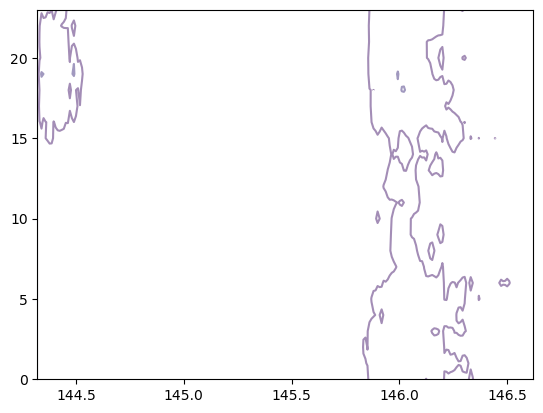

In [170]:
plt.contour(cairns_lon[5:34],np.arange(0,24,1),se_cairns_aest[:, 5:34],levels=level_rr,cmap="viridis",alpha=0.5)
plt.contour(cairns_lon[148:-50],np.arange(0,24,1),se_cairns_aest[:, 148:-50],levels=level_rr,cmap="viridis",alpha=0.5)
# plt.contour(cairns_lon[6:135],np.arange(0,24,1),sw_cairns_aest[:, 6:135],levels=10,cmap="viridis",alpha=0.5)
# plt.contour(cairns_lon[160:-6],np.arange(0,24,1),sw_cairns_aest[:, 160:-6],levels=10,cmap="viridis",alpha=0.5)


In [11]:
# open topography dataset
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

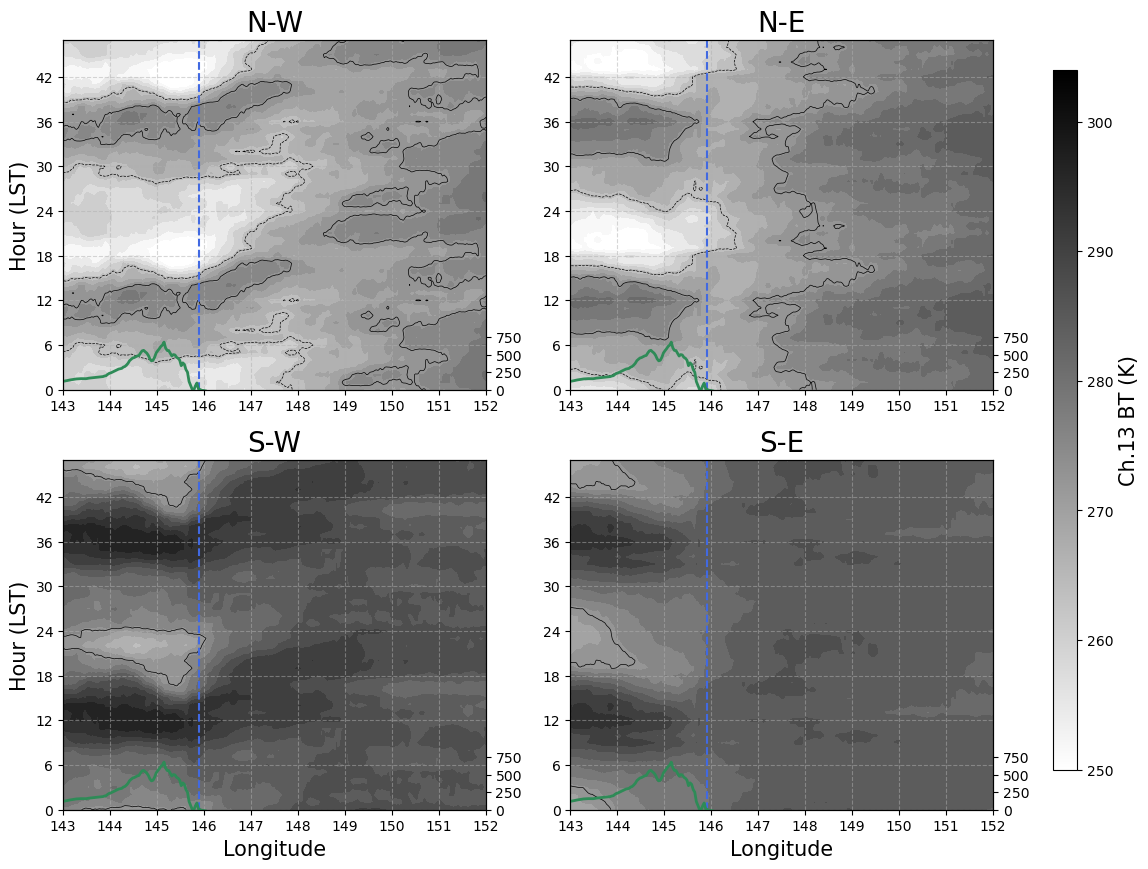

In [30]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
fig.patch.set_facecolor('white')
levels=np.arange(250,305,3)
ax[0,1].contourf(bt_lon,np.arange(0,48,1),ne_double_him_mean,levels=levels,cmap="binary",alpha=1)
ax[0,1].contour(bt_lon,np.arange(0,48,1),ne_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[0,1].contour(bt_lon,np.arange(0,48,1),ne_double_him_mean,levels=[263],colors="black",alpha=1,linewidths=0.5,linestyles='--')
ax[1,1].contourf(bt_lon,np.arange(0,48,1),se_double_him_mean,levels=levels,cmap="binary",alpha=1)
ax[1,1].contour(bt_lon,np.arange(0,48,1),se_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[1,0].contourf(bt_lon,np.arange(0,48,1),sw_double_him_mean,levels=levels,cmap="binary",alpha=1)
ax[1,0].contour(bt_lon,np.arange(0,48,1),sw_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[0,0].contourf(bt_lon,np.arange(0,48,1),nw_double_him_mean,levels=levels,cmap="binary",alpha=1)
ax[0,0].contour(bt_lon,np.arange(0,48,1),nw_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[0,0].contour(bt_lon,np.arange(0,48,1),nw_double_him_mean,levels=[263],colors="black",alpha=1,linewidths=0.5,linestyles='--')

cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# # Create a colorbar using the ScalarMappable from one of the subplots
sm = plt.cm.ScalarMappable(cmap="binary")
sm.set_array(levels)  # You need to set an array for the ScalarMappable
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(label='Ch.13 BT (K)',fontsize=15)

# plot topography
# make twin axis for topography overlay
ax1 = ax[0,0].twinx()
ax1.set_ylim(0,5000)
ax1.set_yticks(np.arange(0,1000,250))
ax1.set_xlim(143,152)
ax2 = ax[0,1].twinx()
ax2.set_ylim(0,5000)
ax2.set_yticks(np.arange(0,1000,250))
ax2.set_xlim(143,152)
ax3 = ax[1,0].twinx()
ax3.set_ylim(0,5000)
ax3.set_yticks(np.arange(0,1000,250))
ax3.set_xlim(143,152)
ax4 = ax[1,1].twinx()
ax4.set_ylim(0,5000)
ax4.set_yticks(np.arange(0,1000,250))
ax4.set_xlim(143,152)
long=ds_bath.sel(y=-16.8,method='nearest').drop_vars('z')
ax1.plot(long.x,ds_bath['z'].sel(y=slice(-16.993225,-16.633728)).mean(dim='y'),color='seagreen',linewidth=2)
# ax1.plot(long.x,ds_bath['z'].sel(y=-16.8,method='nearest'),color='seagreen',linewidth=2)
ax2.plot(long.x,ds_bath['z'].sel(y=slice(-16.993225,-16.633728)).mean(dim='y'),color='seagreen',linewidth=2)
ax3.plot(long.x,ds_bath['z'].sel(y=slice(-16.993225,-16.633728)).mean(dim='y'),color='seagreen',linewidth=2)
ax4.plot(long.x,ds_bath['z'].sel(y=slice(-16.993225,-16.633728)).mean(dim='y'),color='seagreen',linewidth=2)

# level_rr=np.arange(0,0.35,0.03)
# ax[0,1].contour(cairns_lon[6:-6],np.arange(0,48,1),ne_double_cairns,levels=level_rr,cmap="viridis",alpha=0.5)
# # ax[1,1].contour(cairns_lon[11:-6],np.arange(0,48,1),se_double_cairnsv2,levels=level_rr,cmap="viridis",alpha=0.5)
# ax[1,1].contour(cairns_lon[6:34],np.arange(0,48,1),se_double_cairnsv2,levels=level_rr,cmap="viridis",alpha=0.5)
# ax[1,1].contour(cairns_lon[148:-50],np.arange(0,48,1),se_double_cairnsv3,levels=level_rr,cmap="viridis",alpha=0.5)
# ax[1,0].contour(cairns_lon[6:135],np.arange(0,48,1),sw_double_cairnsv2,levels=level_rr,cmap="viridis",alpha=0.5)
# ax[1,0].contour(cairns_lon[160:-6],np.arange(0,48,1),sw_double_cairnsv3,levels=level_rr,cmap="viridis",alpha=0.5)

# ax[0,0].contour(cairns_lon[6:-6],np.arange(0,48,1),nw_double_cairns,levels=level_rr,cmap="viridis",alpha=0.5)
# ax[0,1].contour(willis_lon[17:-17],np.arange(0,48,1),ne_double_willis,levels=level_rr,cmap="viridis",alpha=0.5)
# ax[1,1].contour(willis_lon[17:-17],np.arange(0,48,1),se_double_willis,levels=level_rr,cmap="viridis",alpha=0.5)
# ax[1,0].contour(willis_lon[17:-17],np.arange(0,48,1),sw_double_willis,levels=level_rr,cmap="viridis",alpha=0.5)
# ax[0,0].contour(willis_lon[17:-17],np.arange(0,48,1),nw_double_willis,levels=level_rr,cmap="viridis",alpha=0.5)

# sm_rr = plt.cm.ScalarMappable(cmap="viridis")
# sm_rr.set_array(level_rr)  # You need to set an array for the ScalarMappable
# dax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# cbarrr = plt.colorbar(sm_rr,label='Rain Rate (mm/h)',cax=dax)

            ## cb=plt.colorbar(cf1,label="Rain Rate (mm/h)",ticks=levels,pad=0.05)
            ## norm= matplotlib.colors.Normalize(vmin=cf1.cvalues.min(), vmax=cf1.cvalues.max())
            ## sm = plt.cm.ScalarMappable(norm=norm, cmap = cf1.cmap)
            ## sm.set_array([])
            ## plt.colorbar(sm,label="Rain Rate (mm/h)",ticks=cf1.levels,ax=ax,alpha=0.5)

            # cf2=plt.contour(willis_lon[17:-17],np.arange(0,48,1),double_willis,levels=levels,alpha=0.5,cmap="viridis")
            # plt.colorbar(cf2)
# ax[0,0].contour(cairns_lon[6:-6],np.arange(0,48,1),nw_double_cairns,levels=level_rr,cmap="viridis",alpha=0.5)
# ax[0,1].contour(willis_lon[17:-17],np.arange(0,48,1),ne_double_willis,levels=level_rr,cmap="viridis",alpha=0.5)
ax[1,1].set_xlabel("Longitude",fontsize=15)
ax[1,0].set_xlabel("Longitude",fontsize=15)
ax[1,0].set_ylabel("Hour (LST)",fontsize=15)
ax[0,0].set_ylabel("Hour (LST)",fontsize=15)
ax[0,0].set_yticks(np.arange(0,48,6))
ax[0,1].set_yticks(np.arange(0,48,6))
ax[1,0].set_yticks(np.arange(0,48,6))
ax[1,1].set_yticks(np.arange(0,48,6))
ax[0,1].set_title("N-E",fontsize=20)
ax[1,1].set_title("S-E",fontsize=20)
ax[1,0].set_title("S-W",fontsize=20)
ax[0,0].set_title("N-W",fontsize=20)
ax[0,1].axvline(145.9,color='royalblue',alpha=1,linestyle='--')
ax[1,1].axvline(145.9,color='royalblue',alpha=1,linestyle='--')
ax[1,0].axvline(145.9,color='royalblue',alpha=1,linestyle='--')
ax[0,0].axvline(145.9,color='royalblue',alpha=1,linestyle='--')
ax[0,1].grid(linestyle='--',alpha=0.5)
ax[1,1].grid(linestyle='--',alpha=0.5)
ax[1,0].grid(linestyle='--',alpha=0.5)
ax[0,0].grid(linestyle='--',alpha=0.5)
# ax.set_yticks(np.arange(0,48,6))
# ax.grid()
# # fig.suptitle("Diurnal Brightness Temperature and Rain Rate Hovmöller",fontsize=20);
# ax.set_title("Deep Westerlies",fontsize=20); #Mean for latitudes shared by Cairns and Willis Island radar sites
# ax.text(143.1,1,'n = 210 days',color='purple',fontsize=15)
# ax.text(143.1,3,'n = 98 days',color='black',fontsize=15)

In [109]:
len(wind_times)/24

98.41666666666667

In [110]:
len(merged_500.time)/24

210.95833333333334

In [ ]:
def plot_barra_variables(barra_variable,level,cmap,scm,ne,se,sw,nw,cbar_label,title):
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    fig.patch.set_facecolor('white')
    levels = level
    cf_ne = ax[0,1].contourf(barra_variable.lon,np.arange(0,48,1),ne,levels=levels,cmap=cmap)
    cf_se = ax[1,1].contourf(barra_variable.lon,np.arange(0,48,1),se,levels=levels,cmap=cmap)
    cf_sw = ax[1,0].contourf(barra_variable.lon,np.arange(0,48,1),sw,levels=levels,cmap=cmap)
    cf_nw = ax[0,0].contourf(barra_variable.lon,np.arange(0,48,1),nw,levels=levels,cmap=cmap)
    ax[0,1].contour(barra_variable.lon,np.arange(0,48,1),ne,levels=levels,colors="black",linewidths=1)
    ax[1,1].contour(barra_variable.lon,np.arange(0,48,1),se,levels=levels,colors="black",linewidths=1)
    ax[1,0].contour(barra_variable.lon,np.arange(0,48,1),sw,levels=levels,colors="black",linewidths=1)
    ax[0,0].contour(barra_variable.lon,np.arange(0,48,1),nw,levels=levels,colors="black",linewidths=1)
    # for colorbar plotting
    cax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    # # Create a colorbar using the ScalarMappable from one of the subplots
    sm = plt.cm.ScalarMappable(cmap=scm)
    sm.set_array(levels)  # You need to set an array for the ScalarMappable
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label(cbar_label,fontsize=10)
    yticks = np.arange(0,48,6)
    ax[0,1].set_yticks(yticks)
    ax[1,1].set_yticks(yticks)
    ax[1,0].set_yticks(yticks)
    ax[0,0].set_yticks(yticks)
    
    ax[0,0].set_ylabel('Hour (AEST)')
    ax[1,0].set_ylabel('Hour (AEST)')
    ax[1,0].set_xlabel('Longitude')
    ax[1,1].set_xlabel('Longitude')
    
    ax[0,1].set_title("NE")
    ax[1,1].set_title("SE")
    ax[1,0].set_title("SW")
    ax[0,0].set_title("NW")
    fig.suptitle(title+' Regime Composites')
    return
plot_barra_variables(barra_cairns_rad,np.arange(0,1000,50),"plasma",plt.cm.plasma,sfc_ne,sfc_se,sfc_sw,sfc_nw,'W M-2','Cairns Surface Net SW Flux')